# Generators

This tutorial covers generator modeling in PyPSA-GB, including thermal plants, renewable generators, and the dispatch optimization process.

## What You'll Learn

- Generator types and data sources
- Thermal generator characteristics
- Renewable generator profiles
- Dispatch optimization and merit order
- Capacity factors and utilization

## 1. Setup

In [1]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import folium
from pyproj import Transformer
from _map_utils import prepare_map_network, explore_network_map

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

# Color definitions
colors = {
    'CCGT': '#FF6B35', 'CCGT_hydrogen': '#FF9966', 'nuclear': '#E91E63', 
    'coal': '#424242', 'wind_onshore': '#3B6182', 'wind_offshore': '#6BAED6',
    'solar_pv': '#FFBB00', 'biomass': '#4CAF50', 'large_hydro': '#0868AC',
    'small_hydro': '#08519C', 'OCGT': '#FF9800', 'marine': '#00BCD4',
    'oil': '#795548', 'load_shedding': '#F44336'
}

print(f"PyPSA version: {pypsa.__version__}")

PyPSA version: 1.0.7


## 2. Generator Data Sources

| Source | Type | Used For |
|--------|------|----------|
| **DUKES** | Official UK stats | Historical thermal capacity |
| **REPD** | Planning database | Renewable sites and capacity |
| **FES** | Future scenarios | Future capacity projections |
| **TEC Register** | Grid connections | Large generator verification |

## 3. Load a Network

In [2]:
# Load network
n = pypsa.Network("../../../resources/network/HT35_clustered_solved.nc")

print(f"Network loaded")
print(f"  Total generators: {len(n.generators)}")
print(f"  Unique carriers: {n.generators.carrier.nunique()}")
print(f"  Snapshots: {len(n.snapshots)}")

INFO:pypsa.network.io:Imported network 'HT35_clustered (Clustered)' has buses, carriers, generators, lines, links, loads, storage_units, stores, sub_networks


Network loaded
  Total generators: 4941
  Unique carriers: 20
  Snapshots: 168


## 4. Generator Structure

### 4.1 Generator Attributes

In [3]:
# Generator DataFrame
print("Generator columns:")
print(n.generators.columns.tolist())

print(f"\nKey attributes:")
print("  - bus: Connection point")
print("  - carrier: Technology type")
print("  - p_nom: Nominal capacity (MW)")
print("  - marginal_cost: Cost per MWh")
print("  - efficiency: Conversion efficiency")

Generator columns:
['bus', 'control', 'type', 'p_nom', 'p_nom_mod', 'p_nom_extendable', 'p_nom_min', 'p_nom_max', 'p_nom_set', 'p_min_pu', 'p_max_pu', 'p_set', 'e_sum_min', 'e_sum_max', 'q_set', 'sign', 'carrier', 'marginal_cost', 'marginal_cost_quadratic', 'active', 'build_year', 'lifetime', 'capital_cost', 'efficiency', 'committable', 'start_up_cost', 'shut_down_cost', 'stand_by_cost', 'min_up_time', 'min_down_time', 'up_time_before', 'down_time_before', 'ramp_limit_up', 'ramp_limit_down', 'ramp_limit_start_up', 'ramp_limit_shut_down', 'weight', 'p_nom_opt', 'lon', 'lat', 'data_source', 'country', 'source']

Key attributes:
  - bus: Connection point
  - carrier: Technology type
  - p_nom: Nominal capacity (MW)
  - marginal_cost: Cost per MWh
  - efficiency: Conversion efficiency


In [4]:
# Sample generators
n.generators[['bus', 'carrier', 'p_nom', 'marginal_cost', 'efficiency']].head(10)

bus      carrier  \
name                                                                  
FES_large_hydro_Abham_2035                       ABHA1  large_hydro   
FES_large_hydro_Abernethy_2035                  ABNE_P  large_hydro   
FES_large_hydro_Alness_2035                     ALNE_P  large_hydro   
FES_large_hydro_Alverdiscott_2035                ALVE1  large_hydro   
FES_large_hydro_Ardkinglas_2035          ARDK_P|CLAC_P  large_hydro   
FES_large_hydro_Ardmore_2035                    DUGR_P  large_hydro   
FES_large_hydro_Axminster_2035                   AXMI1  large_hydro   
FES_large_hydro_Beauly_2035              BEAU_P|ORRI_P  large_hydro   
FES_large_hydro_DirectSHETL_BEAU1J_2035  BEAU_P|ORRI_P  large_hydro   
FES_large_hydro_Beddington_SPN_2035             BEDD_1  large_hydro   

                                              p_nom  marginal_cost  efficiency  
name                                                                            
FES_large_hydro_Abham_2035                 1.917000           7.04         1.0  
FES_large_hydro_Abernethy_2035             1.475000           7.04         1.0  
FES_large_hydro_Alness_2035                6.153000           7.04         1.0  
FES_large_hydro_Alverdiscott_2035          2.486000           7.04         1.0  
FES_large_hydro_Ardkinglas_2035            4.661000           7.04         1.0  
FES_large_hydro_Ardmore_2035               0.139000           7.04         1.0  
FES_large_hydro_Axminster_2035             0.048000           7.04         1.0  
FES_large_hydro_Beauly_2035               20.872000           7.04         1.0  
FES_large_hydro_DirectSHETL_BEAU1J_2035  109.857879           7.04         1.0  
FES_large_hydro_Beddington_SPN_2035        0.837000           7.04         1.0

### 4.2 Capacity by Technology

In [5]:
# Installed capacity by carrier
capacity = n.generators.groupby('carrier')['p_nom'].sum().sort_values(ascending=False)
capacity_gw = capacity / 1000

print("Installed Capacity (GW):")
print(capacity_gw.round(2).to_string())
print(f"\nTotal: {capacity_gw.sum():.2f} GW")

Installed Capacity (GW):
carrier
wind_offshore       88.55
load_shedding       82.05
solar_pv            69.19
wind_onshore        31.12
EU_import           26.02
CCGT                 6.84
nuclear              5.00
advanced_biofuel     4.96
biomass              4.96
waste_to_energy      4.24
large_hydro          1.91
biogas               1.70
OCGT                 0.88
landfill_gas         0.86
CHP                  0.48
gas_engine           0.46
marine               0.34
oil                  0.08
sewage_gas           0.06
geothermal           0.01

Total: 329.70 GW


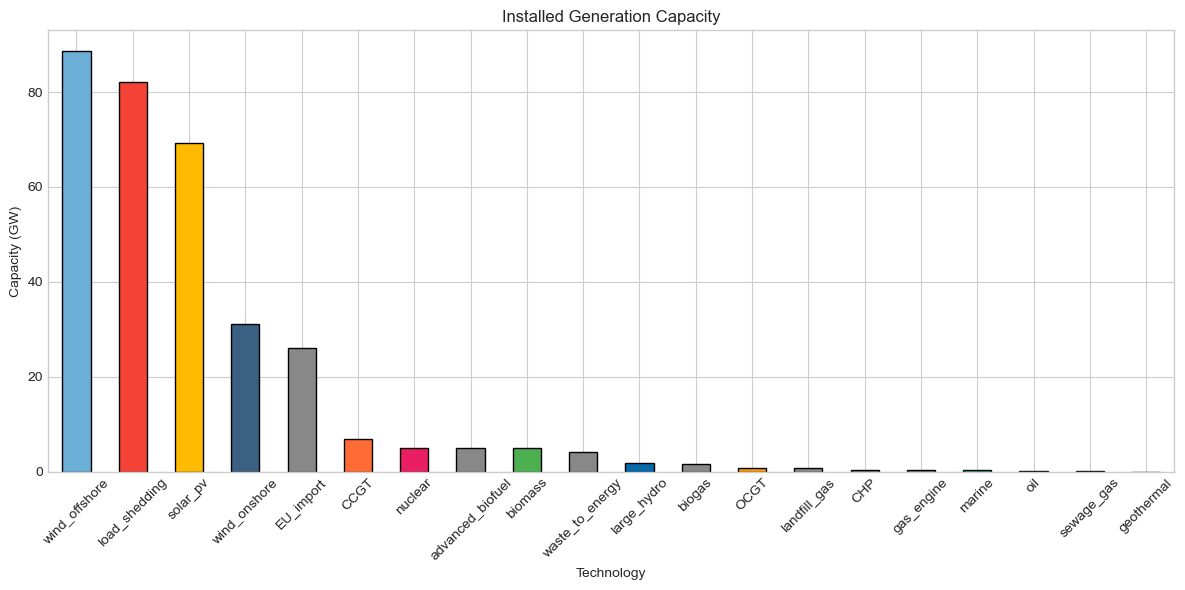

In [6]:
# Capacity bar chart
fig, ax = plt.subplots(figsize=(12, 6))

carrier_colors = [colors.get(c, '#888888') for c in capacity_gw.index]
capacity_gw.plot(kind='bar', ax=ax, color=carrier_colors, edgecolor='black')

ax.set_ylabel('Capacity (GW)')
ax.set_xlabel('Technology')
ax.set_title('Installed Generation Capacity')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 5. Thermal Generators

### 5.1 Characteristics

In [7]:
# Thermal generator types
thermal_carriers = ['CCGT', 'coal', 'OCGT', 'nuclear', 'biomass', 'oil']
thermal_gens = n.generators[n.generators.carrier.isin(thermal_carriers)]

print(f"Thermal Generators: {len(thermal_gens)}")
print(f"\nCapacity by type (GW):")
print(thermal_gens.groupby('carrier')['p_nom'].sum().sort_values(ascending=False) / 1000)

Thermal Generators: 178

Capacity by type (GW):
carrier
CCGT       6.840000
nuclear    5.000000
biomass    4.961803
OCGT       0.878900
oil        0.078500
Name: p_nom, dtype: float64


In [8]:
# Efficiency and marginal costs
thermal_stats = thermal_gens.groupby('carrier').agg({
    'p_nom': 'sum',
    'efficiency': 'mean',
    'marginal_cost': 'mean'
}).round(2)
thermal_stats.columns = ['Capacity (MW)', 'Avg Efficiency', 'Avg Marginal Cost (Â£/MWh)']

print("Thermal Generator Characteristics:")
thermal_stats

Thermal Generator Characteristics:


Capacity (MW)  Avg Efficiency  Avg Marginal Cost (Â£/MWh)
carrier                                                           
CCGT            6840.0             0.5                      152.96
OCGT             878.9             0.5                      152.96
biomass         4961.8             0.5                      110.40
nuclear         5000.0             0.5                       18.04
oil               78.5             0.5                      240.61

### 5.2 Merit Order

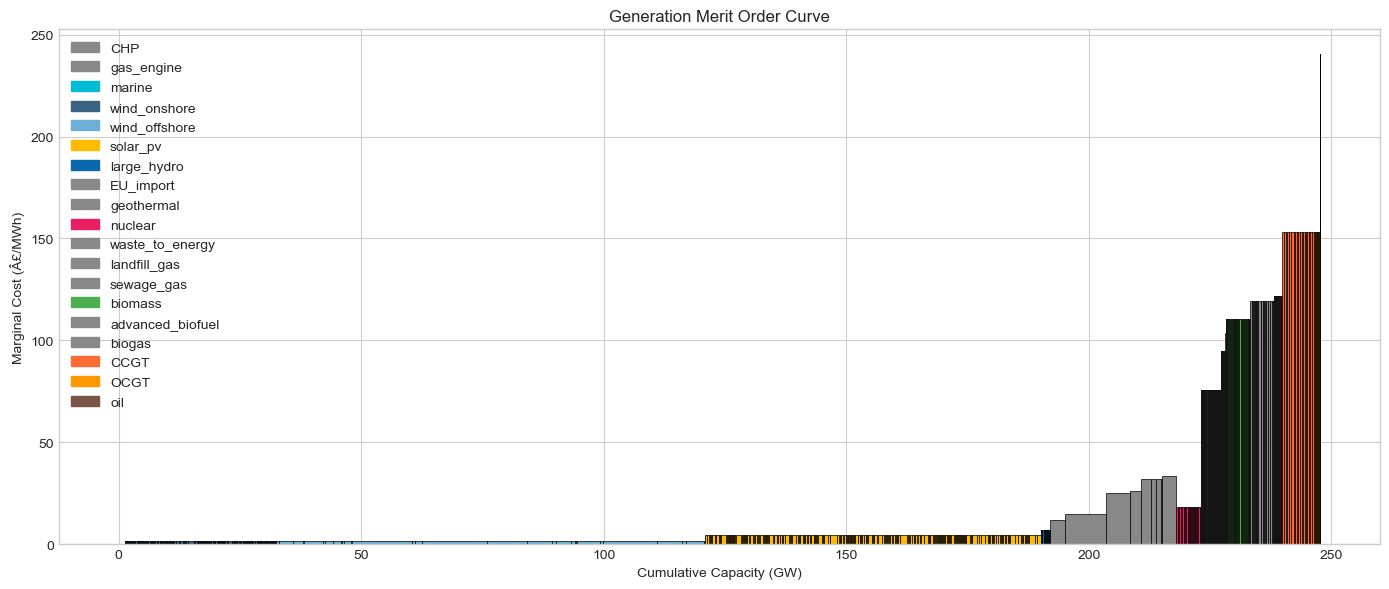

In [9]:
# Merit order curve
gen_costs = n.generators[['carrier', 'p_nom', 'marginal_cost']].copy()
gen_costs = gen_costs[gen_costs.marginal_cost < 1000]  # Exclude load shedding
gen_costs = gen_costs.sort_values('marginal_cost')
gen_costs['cumulative_capacity'] = gen_costs['p_nom'].cumsum() / 1000  # GW

fig, ax = plt.subplots(figsize=(14, 6))

prev_cap = 0
for carrier in gen_costs.carrier.unique():
    carrier_gens = gen_costs[gen_costs.carrier == carrier]
    for _, gen in carrier_gens.iterrows():
        ax.bar(prev_cap + gen['p_nom']/2000, gen['marginal_cost'],
               width=gen['p_nom']/1000, color=colors.get(carrier, '#888888'),
               edgecolor='black', linewidth=0.5)
        prev_cap += gen['p_nom']/1000

# Legend
handles = [plt.Rectangle((0,0),1,1, color=colors.get(c, '#888888')) 
           for c in gen_costs.carrier.unique()]
ax.legend(handles, gen_costs.carrier.unique(), loc='upper left')

ax.set_xlabel('Cumulative Capacity (GW)')
ax.set_ylabel('Marginal Cost (Â£/MWh)')
ax.set_title('Generation Merit Order Curve')

plt.tight_layout()
plt.show()

## 6. Renewable Generators

### 6.1 Capacity Profiles

In [10]:
# Renewable generators
renewable_carriers = ['wind_onshore', 'wind_offshore', 'solar_pv', 'large_hydro', 'small_hydro']
renewable_gens = n.generators[n.generators.carrier.isin(renewable_carriers)]

print(f"Renewable Generators: {len(renewable_gens)}")
print(f"\nCapacity by type (GW):")
print(renewable_gens.groupby('carrier')['p_nom'].sum().sort_values(ascending=False) / 1000)

Renewable Generators: 1340

Capacity by type (GW):
carrier
wind_offshore    88.553202
solar_pv         69.185866
wind_onshore     31.121222
large_hydro       1.914408
Name: p_nom, dtype: float64


In [11]:
# Check for availability time series
if 'p_max_pu' in n.generators_t:
    print("Availability profiles (p_max_pu) available")
    
    # Sample availability for each carrier
    for carrier in renewable_carriers:
        carrier_gens = n.generators[n.generators.carrier == carrier].index
        if len(carrier_gens) > 0:
            # Get first generator of this type that has a profile
            for gen in carrier_gens:
                if gen in n.generators_t.p_max_pu.columns:
                    cf = n.generators_t.p_max_pu[gen].mean()
                    print(f"  {carrier}: avg CF = {cf*100:.1f}%")
                    break
else:
    print("No availability profiles found")

Availability profiles (p_max_pu) available
  wind_onshore: avg CF = 42.8%
  wind_offshore: avg CF = 51.6%
  solar_pv: avg CF = 9.6%
  large_hydro: avg CF = 40.0%


### 6.2 Renewable Output Profiles

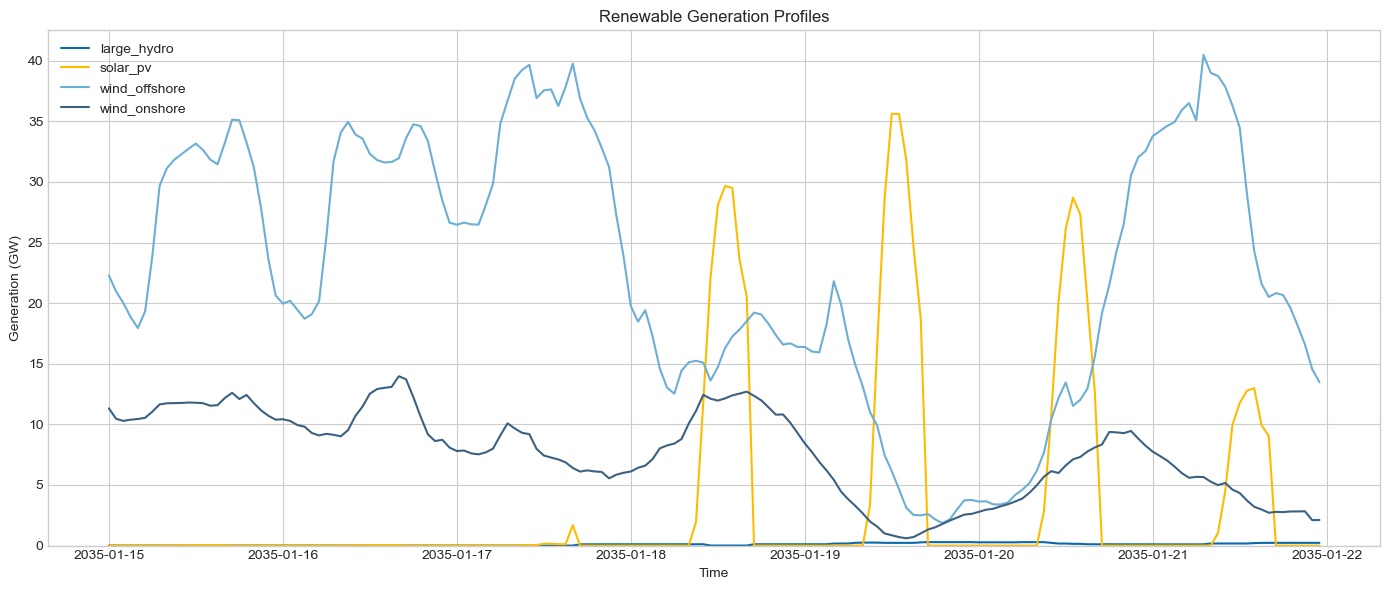

In [12]:
# Generation profiles by renewable type
renewable_gen = n.generators_t.p[[g for g in renewable_gens.index if g in n.generators_t.p.columns]]

if len(renewable_gen.columns) > 0:
    # Aggregate by carrier
    gen_by_carrier = renewable_gen.groupby(n.generators.loc[renewable_gen.columns, 'carrier'], axis=1).sum() / 1000
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    for carrier in gen_by_carrier.columns:
        ax.plot(gen_by_carrier.index, gen_by_carrier[carrier], 
               label=carrier, linewidth=1.5, color=colors.get(carrier, '#888888'))
    
    ax.set_ylabel('Generation (GW)')
    ax.set_xlabel('Time')
    ax.set_title('Renewable Generation Profiles')
    ax.legend()
    ax.set_ylim(bottom=0)
    
    plt.tight_layout()
    plt.show()

## 7. Generator Spatial Distribution

In [13]:
# Capacity by bus
bus_capacity = n.generators.groupby('bus')['p_nom'].sum() / 1000  # GW

map_n = prepare_map_network(n)
map_n.buses["capacity_GW"] = bus_capacity.reindex(map_n.buses.index).fillna(0)

print("Generation Capacity Distribution (Bus size = capacity)")
print("lon range:", float(map_n.buses.x.min()), float(map_n.buses.x.max()))
print("lat range:", float(map_n.buses.y.min()), float(map_n.buses.y.max()))

# Interactive network map with capacity-based bus sizing
m = map_n.plot.explore(
    map_style="light",
    tooltip=True,
    bus_size=map_n.buses["capacity_GW"].clip(lower=0.1) * 1000,
    bus_size_factor=0.05,
    branch_width_factor=1.0,
    bus_columns=["capacity_GW", "v_nom"],
)
m


Generation Capacity Distribution (Bus size = capacity)
lon range: -6.960335346509393 9.1167
lat range: 50.394884755225235 59.349999999999994


{
  "initialViewState": {
    "bearing": 0,
    "latitude": 54.22413038840103,
    "longitude": -2.41734556444839,
    "pitch": 0,
    "zoom": 4
  },
  "layers": [
    {
      "@@type": "PathLayer",
      "autoHighlight": true,
      "data": [
        {
          "bus0": "CONQA1|SASA",
          "bus1": "CAFA|EAST|GLLE|KEOO|TONG1",
          "color": "darkseagreen",
          "name": "2954",
          "path": [
            [
              -3.3544963425708576,
              53.23871562348152
            ],
            [
              -4.163099217879353,
              55.01587255132321
            ]
          ],
          "rgba": [
            143,
            188,
            143,
            230
          ],
          "tooltip_html": "<b>2954</b>\n<table>\n<tr><td style='font-weight:bold'>bus0:</td><td style='text-align:left'>CONQA1|SASA</td></tr>\n<tr><td style='font-weight:bold'>bus1:</td><td style='text-align:left'>CAFA|EAST|GLLE|KEOO|TONG1</td></tr>\n<tr><td style='font-weight:bold'>color:</td><td style='text-align:left'>darkseagreen</td></tr>\n<tr><td style='font-weight:bold'>width:</td><td style='text-align:left'>2</td></tr>\n</table>",
          "width": 2,
          "width_pdk": 2000.0
        },
        {
          "bus0": "THSO_P",
          "bus1": "BERB_P|CAIF_P|DALL_P|GLEF_P|KEIT_P",
          "color": "darkseagreen",
          "name": "2955",
          "path": [
            [
              -3.4874794268326674,
              58.57926665176981
            ],
            [
              -2.8494635317620247,
              57.50394756914673
            ]
          ],
          "rgba": [
            143,
            188,
            143,
            230
          ],
          "tooltip_html": "<b>2955</b>\n<table>\n<tr><td style='font-weight:bold'>bus0:</td><td style='text-align:left'>THSO_P</td></tr>\n<tr><td style='font-weight:bold'>bus1:</td><td style='text-align:left'>BERB_P|CAIF_P|DALL_P|GLEF_P|KEIT_P</td></tr>\n<tr><td style='font-weight:bold'>color:</td><td style='text-align:left'>darkseagreen</td></tr>\n<tr><td style='font-weight:bold'>width:</td><td style='text-align:left'>2</td></tr>\n</table>",
          "width": 2,
          "width_pdk": 2000.0
        },
        {
          "bus0": "DYCE_P",
          "bus1": "BERB_P|CAIF_P|DALL_P|GLEF_P|KEIT_P",
          "color": "darkseagreen",
          "name": "2956",
          "path": [
            [
              -2.1347581816127383,
              57.29443305449862
            ],
            [
              -2.8494635317620247,
              57.50394756914673
            ]
          ],
          "rgba": [
            143,
            188,
            143,
            230
          ],
          "tooltip_html": "<b>2956</b>\n<table>\n<tr><td style='font-weight:bold'>bus0:</td><td style='text-align:left'>DYCE_P</td></tr>\n<tr><td style='font-weight:bold'>bus1:</td><td style='text-align:left'>BERB_P|CAIF_P|DALL_P|GLEF_P|KEIT_P</td></tr>\n<tr><td style='font-weight:bold'>color:</td><td style='text-align:left'>darkseagreen</td></tr>\n<tr><td style='font-weight:bold'>width:</td><td style='text-align:left'>2</td></tr>\n</table>",
          "width": 2,
          "width_pdk": 2000.0
        },
        {
          "bus0": "DYCE_P",
          "bus1": "H2_gas_GB_H2",
          "color": "darkseagreen",
          "name": "electrolysis_ABBA1-",
          "path": [
            [
              -2.1347581816127383,
              57.29443305449862
            ],
            [
              -1.2819026533792304,
              53.41132084626268
            ]
          ],
          "rgba": [
            143,
            188,
            143,
            230
          ],
          "tooltip_html": "<b>electrolysis_ABBA1-</b>\n<table>\n<tr><td style='font-weight:bold'>bus0:</td><td style='text-align:left'>DYCE_P</td></tr>\n<tr><td style='font-weight:bold'>bus1:</td><td style='text-align:left'>H2_gas_GB_H2</td></tr>\n<tr><td style='font-weight:bold'>color:</td><td style='text-align:left'>darkse